# Using Principal Component Analysis for Digital Signal Processing
### Ayush Chakraborty, Allyson Hur, Cherry Pham, Suki Sacks

## Abstract
Digital Signal Processing (DSP) involves manipulating and analyzing signals to extract meaningful information. DSP normally relies on predefined algorithms and mathematical models for signal-processing tasks. This project explores the integration of principal component analysis (PCA) into DSP to enhance its capabilities and adaptability, and also to draw connections to the methods we used in linear algebra.

The objective of this project is to investigate how PCA can be used for tasks such as signal denoising, modulation recognition, and feature extraction. We explore different channel models to assess how our PCA DSP implementation functions with differing conditions. 

### What is Principal Component Analysis (PCA)?
PCA is a dimensionality reduction technique used to transform the data into a new coordinate system in which the axes (basis vectors) are equivalent to the directions of maximum variance. The first principle component is the direction in which our symbols vary the most. In this case, our four symbols are -1, -0.3, 0.3, and 1. PCA will map these symbols into 1D representations of the variation. 

### Why don't we need to demodulate our signal when using PCA? 

When running through our "base case" channel with just Gaussian noise, we did not have to demodulate when peforming PCA on our 4-PAM to get a good bit error rate (BER). In fact, when we demodulated, it actually increased the BER. Since we are projecting our different symbols into eigenvectors to separate them by frequency, we don't have to demodulate the signal to separate the various properties of our message because PCA has already done that for us! This is the same case with the Fourier Transform, which already separates the various sinusoidal functions into different frequencies. 

### A little more about the Fourier Transform...
The Fourier Transform transforms a function of time into its frequency components by representing a function as a sum of sin and cosine waves (sinusoidal functions) with different frequencies. These waves function as the basis vectors in the frequency domain, representing different frequencies in the signal. 

## Implementation
The code block below runs the code to perform PCA DSP on the following transfer functions in the order of (1) DiracDelta, (2) Sinc, (3) Sine, (4) Cosine, and (5) Triangle and display the corresponding Signal-to-Noise Ratio vs. Variance and Bit Error Rate vs. Variance for each of the transfer functions. Throughout this Jupyter Notebook, we explore how effective our PCA DSP implementation is for varying channel models. 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


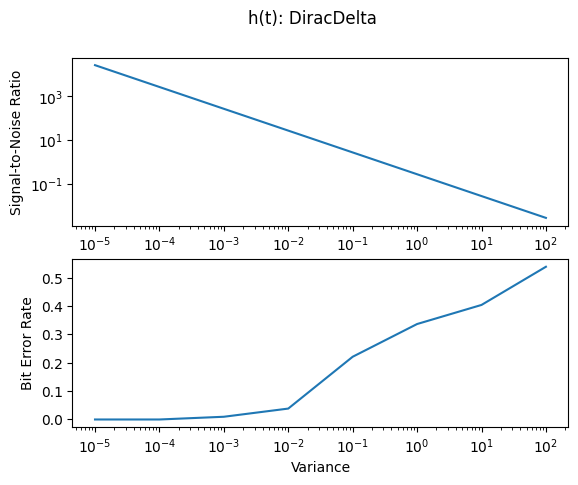

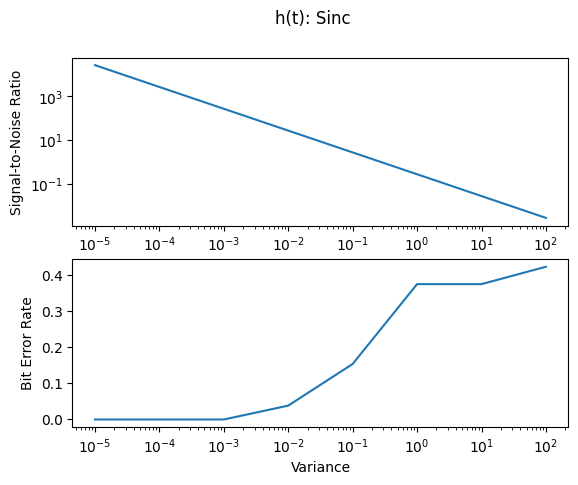

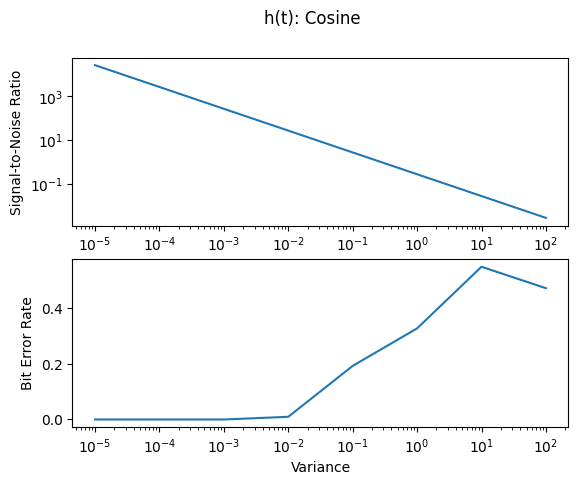

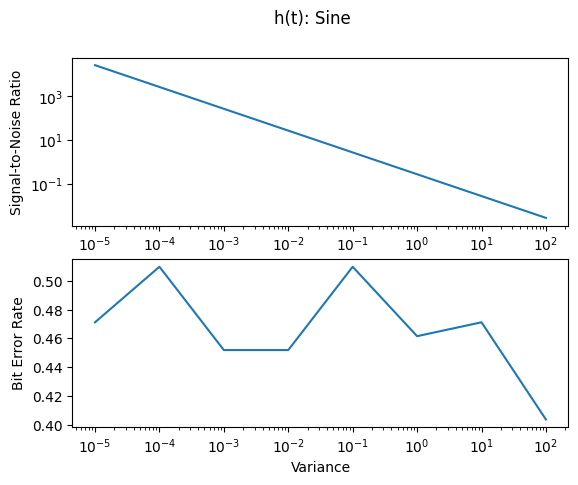

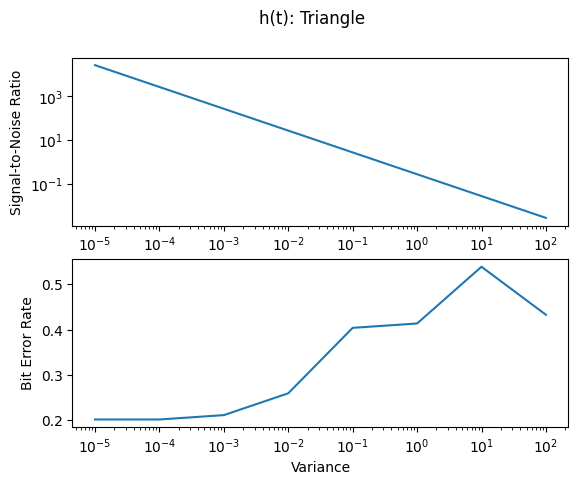

In [1]:
%run pca.py

## PCA DSP Breakdown: Dirac Delta
Below is a breakdown of our PCA implementation using a simple model with Gaussian noise and a dirac delta `h(t)`. This implementation is identical for our other channel models (`sinc`, `sine`, `cosine`, and `triangle`), which we will explore the outcome of after the breakdown. 

In [2]:
# Imports
from itertools import islice
import scipy.stats as stats
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
from plotting import *
from pca import *

# Sampling Parameters
F_SAMPLE = 1e6  # Hz
SAMPLES_PER_SYMBOL = 200
BITS_PER_SYMBOL = 2
F_C = 50e3  # Hz
dt = 1 / F_SAMPLE
T_symbol = SAMPLES_PER_SYMBOL * dt

symbol_zeros = np.zeros((SAMPLES_PER_SYMBOL,))

# Zero-mean Gaussian noise
variance = 1e-3
noiseRV = stats.norm(loc=0.0, scale=np.sqrt(variance))

## Create Binary Message
First, a message in text , `messgage_txt`, is being transcribed into a binary string, `message_bits_txt`. In this case, we convert the original string “Hello, world.” into a binary representation. 

In [3]:
message_txt = "Hello, world."
test_message_bits_txt = ''.join([f"{ord(x):08b}" for x in message_txt])
test_message_bits = np.array([int(b, 2) for b in test_message_bits_txt])

print(f"T: {message_txt} -> {test_message_bits_txt}")

T: Hello, world. -> 01001000011001010110110001101100011011110010110000100000011101110110111101110010011011000110010000101110


Once we've imported everything, created a binary message, and set our parameters and noise, we must create our symbols following the model:
m[k] -> Encoder -> Symbols -> Modulator -> x(t)

### Symbol Construction
The message text is first converted to a 8-bit binary string. The binary message is then split into chunks, where each chunk is converted to an integer with its corresponding symbol. Then, we generate a list of PAM signals, each corresponding to a symbol index within a specified range using the function PAMGenerator. The function takes a symbol index, the modulation order (defaulting to 2, indicating binary PAM), and the number of samples per symbol in the generated PAM signal (defaulting to 10). The PAMGenerator function then generates a PAM signal by selecting the appropriate amplitude level for the given symbol index and repeating it for the specified number of samples per symbol. The resulting signal is a series of identical amplitude values representing the PAM signal for the given symbol.

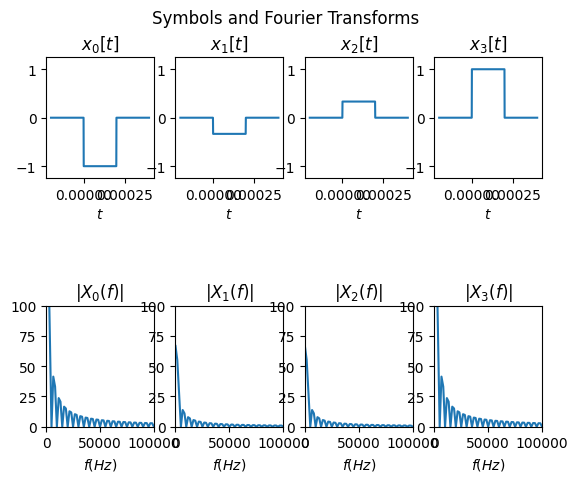

In [4]:
from pca import PAMGenerator
from matplotlib import pyplot as plt
from plotting import real_fft_plot
import numpy as np

class SymbolContruction:
   def __init__(self, BITS_PER_SYMBOL, SAMPLES_PER_SYMBOL):
       self.BITS_PER_SYMBOL = BITS_PER_SYMBOL
       self.SAMPLES_PER_SYMBOL = SAMPLES_PER_SYMBOL

   def symbols_of_t(self):
       symbols_of_t = []
       N_symbols = 2**self.BITS_PER_SYMBOL
       fig, ax = plt.subplots(2, N_symbols)
       plt.subplots_adjust(hspace=1.05)
       for symbol in range(N_symbols):
           x = PAMGenerator(
               symbol, k=N_symbols, samples_per_symbol=self.SAMPLES_PER_SYMBOL
           )
           symbols_of_t.append(x)
           x = np.concatenate((symbol_zeros, x, symbol_zeros))
           t = np.linspace(-1*T_symbol, 2*T_symbol, len(x))
           real_fft_plot(t, x, ax[0][symbol], ax[1][symbol], dt,
                         t_label='$x_{%d}[t]$'%symbol, f_label='$|X_{%d}(f)|$'%symbol)

       return symbols_of_t

SymbolContruction_test = SymbolContruction(BITS_PER_SYMBOL=2, SAMPLES_PER_SYMBOL=200)
test_symbols_of_t = SymbolContruction_test.symbols_of_t()

plt.suptitle("Symbols and Fourier Transforms")
plt.show()
plt.close()

The above graphs are our four symbols in the time and frequency domains. 

### Encoding the binary message
Next, we must translate the binary message bits into a continuous waveform with `x` being the continuous waveform representing the translated message and `t` being the time values corresponding to the waveform.

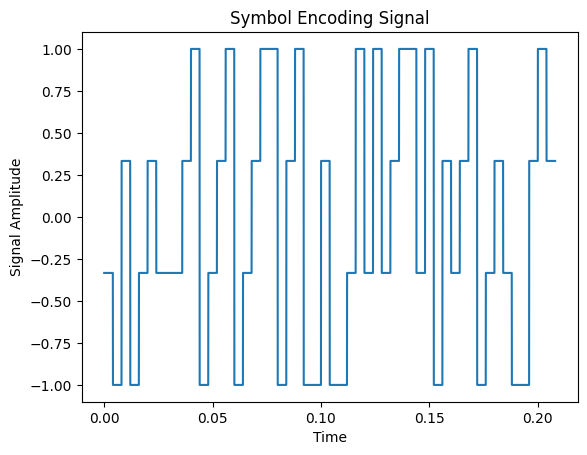

In [5]:
from pca import batched

class SymbolEncoding:
    def __init__(self, BITS_PER_SYMBOL, SAMPLES_PER_SYMBOL, F_C, symbols_of_t, message_bits_txt):
       self.BITS_PER_SYMBOL = BITS_PER_SYMBOL
       self.SAMPLES_PER_SYMBOL = SAMPLES_PER_SYMBOL
       self.symbols_of_t = symbols_of_t
       self.message_bits_txt = message_bits_txt
       self.dt = 1 / F_C

    def x(self):
        """
        Divide the binary message into chunks, then convert each chunk into an
        integer. Then, find the PAM symbol corresopnding to the integer.

        Returns:
            An array of PAM symbols.
        """
        x_samples = self.SAMPLES_PER_SYMBOL * int(
            np.ceil(len(self.message_bits_txt) // self.BITS_PER_SYMBOL)
        )
        x = np.zeros(x_samples,)

        for i, symbol in enumerate(
            batched(self.message_bits_txt, self.BITS_PER_SYMBOL)
        ):
            if not symbol:
                continue
            symbol = int("".join(symbol), 2)
            i_start = i * self.SAMPLES_PER_SYMBOL
            i_end = (i + 1) * self.SAMPLES_PER_SYMBOL
            x[i_start:i_end] = self.symbols_of_t[symbol]

        return x

    def t(self):
        """
        Get the time values associated with each sample in the signal.

        Returns:
            An array representing the time values.
        """
        x_samples = self.SAMPLES_PER_SYMBOL * int(
            np.ceil(len(self.message_bits_txt) // self.BITS_PER_SYMBOL)
        )
        return np.linspace(0, self.dt * x_samples, x_samples)
  

symbols_of_t = test_symbols_of_t
message_bits_txt = test_message_bits_txt

symbol_encoding_test = SymbolEncoding(BITS_PER_SYMBOL, SAMPLES_PER_SYMBOL, F_C, test_symbols_of_t, message_bits_txt)
test_x = symbol_encoding_test.x()
test_t = symbol_encoding_test.t()

plt.plot(test_t, test_x)
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('Symbol Encoding Signal')
plt.show()

## Modulating the signal
We modulate our signal by multiplying the signal by cosine at the carrier frequency `f_c`. This shifts the signal from being centered at zero to being centered around `f_c`. This way, we can bandpass filter our signal to get the original message even after passing it through a noisy channel. 

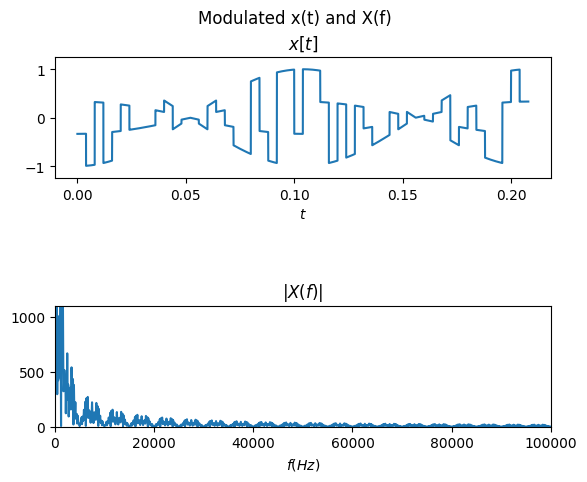

In [6]:
class SymbolModulation:
    def __init__(self, BITS_PER_SYMBOL, SAMPLES_PER_SYMBOL, F_C, symbols_of_t, message_bits_txt, x_values, t_values):
       self.BITS_PER_SYMBOL = BITS_PER_SYMBOL
       self.SAMPLES_PER_SYMBOL = SAMPLES_PER_SYMBOL
       self.symbols_of_t = symbols_of_t
       self.message_bits_txt = message_bits_txt
       self.F_C = F_C
       self.dt = 1 / F_C
       self.x = x_values
       self.t = t_values

    def x_modulated(self):
        """
        Generate the modulated signal by multiplying the generated symbol by a 
        cosine wave at the carrier frequency.

        Returns:
            An array representing the modulated signal.
        """
        return self.x * np.cos(2 * np.pi * self.F_C * self.t)

fig, ax = plt.subplots(2,1)
plt.subplots_adjust(hspace=1.05)
symbol_modulation_test = SymbolModulation(BITS_PER_SYMBOL, SAMPLES_PER_SYMBOL, F_C, symbols_of_t, message_bits_txt, test_x, test_t)
x_modulated_test = symbol_modulation_test.x_modulated()
real_fft_plot(test_t, x_modulated_test, ax[0], ax[1], dt, t_label='$x[t]$', f_label='$|X(f)|$', abs_xlim=1.1e3)
plt.suptitle("Modulated x(t) and X(f)")
plt.show()
plt.close()

### Actually do the PCA!
For the given set of symbols, we compute the eigen symbols to allow us to find the principal eigenvectors later on in the process. This will give us the corresponding coefficients for the eigen symbols, allowing us to efficiently decode our message. 

In [7]:
def compute_eigen_symbols(symbols_of_t):
    """
    Compute the eigen symbols for a given set of PAM symbols.

    Parameters:
    - symbols_of_t (list): A list of PAM symbols, where each element represents a PAM signal for a specific symbol.

    Returns:
    - coefs: The coefficients of the eigen symbols.
    - principal_eig_vec: The principal eigen vector.
    """
    cov = np.cov(symbols_of_t, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    principal_eig_vec = eig_vec[0]

    s0 = (symbols_of_t[0] @ principal_eig_vec.T).real
    s1 = (symbols_of_t[1] @ principal_eig_vec.T).real
    s2 = (symbols_of_t[2] @ principal_eig_vec.T).real
    s3 = (symbols_of_t[3] @ principal_eig_vec.T).real

    return np.array([s0, s1, s2, s3]), principal_eig_vec

coefs, principal_eig_vec = compute_eigen_symbols(symbols_of_t)

### Decoding the Signal
Once we have computed the eigen symbols for a given set of PAM symbols, we can decode the signals using the principal eigenvector. Each of the coefficients map to a principal component of their respective symbol. 

First, we project a selected chunk of the signal `curr_chunk` onto the principal eigenvector to obtain the principal component coefficients. We use `.real` to ensure that the coefficient is a real number and cut out all of the unimportant imaginary portions. We then retrieve the keys, or principal component coefficients, from the `pca_coef_to_symbol` dictionary. With the correct coefficient, we can find the closest principal component coefficient in the dictionary and retrieve the corresponding symbol!

In [18]:
pca_coef_to_symbol = {
	coefs[0].real: [0, 0],
	coefs[1].real: [0, 1],
	coefs[2].real: [1, 0],
	coefs[3].real: [1, 1],
}

def decode_signal(pca_coef_to_symbol, principal_eig_vec, y):
	"""
	Decode a signal using the principal eigen vector.
    
	Parameters:
	- pca_coef_to_symbol (dict): A dictionary mapping the principal component coefficients to their respective symbols.
	- principal_eig_vec: The principal eigen vector.
	- y: The signal to be decoded.
    
	Returns:
	- x_hat: The decoded signal.
	"""
	i = 0
	x_hat = []

	# samples_per_symbol have been changed to SAMPLES_PER_SYMBOL
	while i < len(y):
		curr_chunk = y[i : i + SAMPLES_PER_SYMBOL]
		chunk_coef = (curr_chunk @ principal_eig_vec.T).real
		x_hat.extend(pca_coef_to_symbol[coefs[np.argmin(np.abs(coefs - chunk_coef))]])
		i += SAMPLES_PER_SYMBOL

	return x_hat

x_hat = decode_signal(pca_coef_to_symbol, principal_eig_vec, x_modulated_test)

# Convert list of reconstructed symbols into a binary bitstring.
x_hat_bitstring = "".join(map(str, x_hat))

# Decode bitstring to ASCII characters
x_hat_ascii = bits2a(x_hat_bitstring)

print(x_hat_ascii)

# Calculate average transmitted power
tx_avg_power = np.mean(x_modulated_test**2.0)

# Calculate power of additive noise
noise_power = variance

# Calculate signal-to-noise ratio
snr = tx_avg_power / noise_power

# Calculate bit error rate
ber = np.sum(x_hat != test_message_bits) / len(test_message_bits)

# Display calculated performance metrics
print(f"{tx_avg_power=}")
print(f"{noise_power=}")
print(f"{snr=}")
print(f"{ber=}")

HeiVÓßid.
tx_avg_power=0.2795870942252896
noise_power=0.001
snr=279.5870942252896
ber=0.46153846153846156


## Alternative Channels
Now that we have walked through our PCA implementation of DSP, let's see what the decoding process looks like for different channels. 